# Introduction


This problem is a old competition from Kaggle which can be found here: https://www.kaggle.com/c/movie-review-sentiment-analysis-kernels-only/overview


The basic overview of the problem is as follows: 

The dataset is a set of reviews from rotten tomatoes, a website for reviewing films. 

We want to be able to input a review of a film and about a score of the film. In this setting the score is the label that is output from a model and can have five distinct value. 

The sentiment labels are:

0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive

The goal is to be able to this process with as high accuracy as possible. 

For more information visit the kaggle competition website. 



In [1]:
import numpy as np 
import pandas as pd 
import os
print(os.listdir("../input"))
import gc

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,LSTM,Conv1D,GlobalMaxPooling1D,Flatten,MaxPooling1D,GRU,SpatialDropout1D,Bidirectional
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score
import matplotlib.pyplot as plt


['train.tsv.zip', 'sampleSubmission.csv', 'test.tsv.zip']


Using TensorFlow backend.


These are the files avalible in the Kaggle kernel. 

# EDA

In [2]:
gc.collect()

0

### Loading dataset and basic visualization

In [3]:
train=pd.read_csv('../input/train.tsv.zip',sep='\t')
print(train.shape)
train.head()

(156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [4]:
test=pd.read_csv('../input/test.tsv.zip',sep='\t')
print(test.shape)
test.head()

(66292, 3)


,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [5]:
sub=pd.read_csv('../input/sampleSubmission.csv')
sub.head()

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2


Lets get some feeling for how a sentence is broken down into several phrases.

In [6]:
train.loc[train.SentenceId == 17]

,PhraseId,SentenceId,Phrase,Sentiment
458,459,17,"a bilingual charmer , just like the woman who ...",3
459,460,17,"a bilingual charmer ,",3
460,461,17,a bilingual charmer,3
461,462,17,bilingual charmer,3
462,463,17,bilingual,2
463,464,17,charmer,3
464,465,17,just like the woman who inspired it,2
465,466,17,like the woman who inspired it,2
466,467,17,the woman who inspired it,2
467,468,17,the woman,2


Here we see a potential problem. Differnet phrases in the same sentence will get different sentiments. It is especially intresting that the phrase "billingual charmer" has sentiment 3, while "billingual" and "charmer" gets a "2". This means that words do not only impact seperally but can magnify each others meaning. 

However, in some cases that is not obious. For example "inspired it" and "inspired" have different sentiments. 

In [7]:
print('Average count of phrases per sentence in train is {0:.0f}.'.format(train.groupby('SentenceId')['Phrase'].count().mean()))
print('Average count of phrases per sentence in test is {0:.0f}.'.format(test.groupby('SentenceId')['Phrase'].count().mean()))
print('Number of phrases in train: {}. Number of sentences in train: {}.'.format(train.shape[0], len(train.SentenceId.unique())))
print('Number of phrases in test: {}. Number of sentences in test: {}.'.format(test.shape[0], len(test.SentenceId.unique())))
print('Average word length of phrases in train is {0:.0f}.'.format(np.mean(train['Phrase'].apply(lambda x: len(x.split())))))
print('Average word length of phrases in test is {0:.0f}.'.format(np.mean(test['Phrase'].apply(lambda x: len(x.split())))))

Average count of phrases per sentence in train is 18.
Average count of phrases per sentence in test is 20.
Number of phrases in train: 156060. Number of sentences in train: 8529.
Number of phrases in test: 66292. Number of sentences in test: 3310.
Average word length of phrases in train is 7.
Average word length of phrases in test is 7.


### Wordcloud

In [9]:
df_train_first = train.loc[train['SentenceId'].diff() != 0] #only extracts the first phrase for each sentence (full sentence)

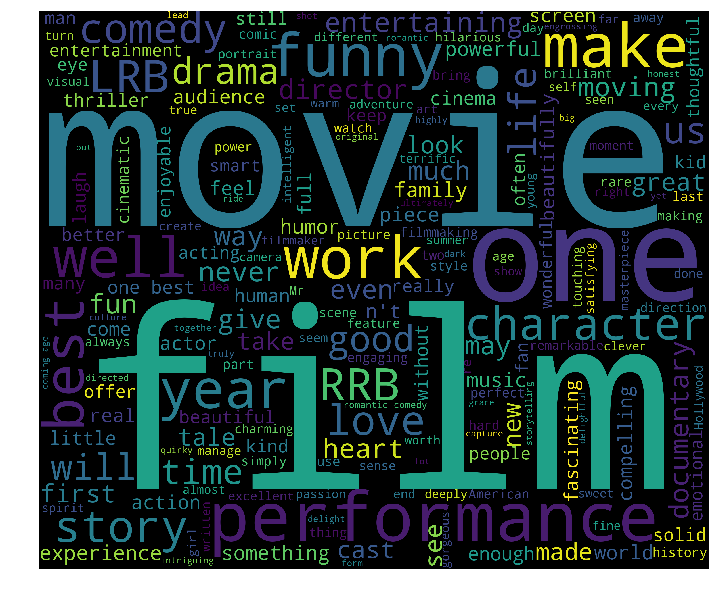

In [10]:
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt 


df_temp = df_train_first.loc[df_train_first['Sentiment']==4]

words = ' '.join(df_temp['Phrase'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                                and word !='&amp'
                            ])

stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

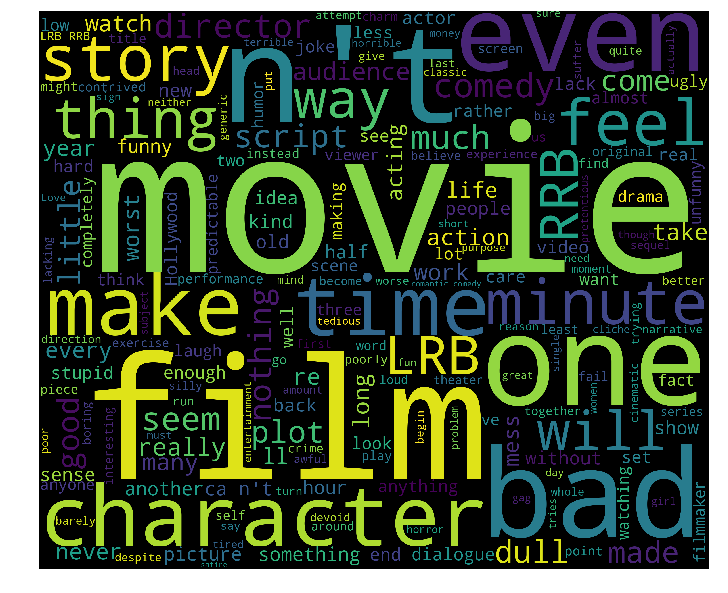

In [11]:
df_temp = df_train_first[df_train_first['Sentiment']==0]

words = ' '.join(df_temp['Phrase'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                                and word !='&amp'
                            ])

stopwords = set(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Pre-processing 

**Adding Sentiment column to test datset and joing train and test for preprocessing**

In [12]:
test['Sentiment']= -999
test.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,156061,8545,An intermittently pleasing but mostly routine ...,-999
1,156062,8545,An intermittently pleasing but mostly routine ...,-999
2,156063,8545,An,-999
3,156064,8545,intermittently pleasing but mostly routine effort,-999
4,156065,8545,intermittently pleasing but mostly routine,-999


In [13]:
df=pd.concat([train,test],ignore_index=True)
print(df.shape)


(222352, 4)


In [14]:
del train,test # free up space
gc.collect() 

4424

In [15]:
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import SnowballStemmer,WordNetLemmatizer
stemmer=SnowballStemmer('english')
lemma=WordNetLemmatizer()
from string import punctuation
import re

In [16]:
def clean_review(review_col):
    review_corpus=[]
    for i in range(0,len(review_col)):
        review=str(review_col[i])
        review=re.sub('[^a-zA-Z]',' ',review)
        #review=[stemmer.stem(w) for w in word_tokenize(str(review).lower())]
        review=[lemma.lemmatize(w) for w in word_tokenize(str(review).lower())]
        review=' '.join(review)
        review_corpus.append(review)
    return review_corpus

In [17]:
df['clean_review']=clean_review(df.Phrase.values)
df.head()

,PhraseId,SentenceId,Phrase,Sentiment,clean_review
0,1,1,A series of escapades demonstrating the adage ...,1,a series of escapade demonstrating the adage t...
1,2,1,A series of escapades demonstrating the adage ...,2,a series of escapade demonstrating the adage t...
2,3,1,A series,2,a series
3,4,1,A,2,a
4,5,1,series,2,series


In [18]:
df_train=df[df.Sentiment!= -999]
df_train.shape


(156060, 5)

In [20]:
df_test=df[df.Sentiment == -999]
df_test.shape


(66292, 5)

In [21]:
del df
gc.collect()


66

## Split the data

In [22]:
train_text=df_train.clean_review.values
test_text=df_test.clean_review.values
target=df_train.Sentiment.values
y=to_categorical(target)
print(train_text.shape,target.shape,y.shape)


(156060,) (156060,) (156060, 5)


In [23]:
# stratify allows equal split over all classes
X_train_text,X_val_text,y_train,y_val=train_test_split(train_text,y,test_size=0.2,stratify=y,random_state=123)
print(X_train_text.shape,y_train.shape)
print(X_val_text.shape,y_val.shape)

(124848,) (124848, 5)
(31212,) (31212, 5)


# Modeling 

## Tokenization

In [24]:
#determining number of unique words
all_words=' '.join(X_train_text)
all_words=word_tokenize(all_words)
dist=FreqDist(all_words)
num_unique_word=len(dist)
num_unique_word

13732

In [25]:
# Determening the maximum lenght of a review (number of words)
r_len=[]
for text in X_train_text:
    word=word_tokenize(text)
    l=len(word)
    r_len.append(l)
    
MAX_REVIEW_LEN=np.max(r_len)
MAX_REVIEW_LEN

48

In [26]:
max_features = num_unique_word
max_words = MAX_REVIEW_LEN

In [27]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train_text))
X_train = tokenizer.texts_to_sequences(X_train_text)
X_val = tokenizer.texts_to_sequences(X_val_text)
X_test = tokenizer.texts_to_sequences(test_text)

In [28]:
from keras.preprocessing import sequence,text
''' 
This function transforms a list (of length num_samples) of sequences (lists of integers) 
into a 2D Numpy array of shape (num_samples, num_timesteps). 
num_timesteps is either the maxlen argument if provided,
or the length of the longest sequence in the list. '''

X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_val = sequence.pad_sequences(X_val, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_val.shape,X_test.shape)

(124848, 48) (31212, 48) (66292, 48)


# logistic regression

Is used as a baseline model

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(ngram_range=(1,2),max_df=0.95,min_df=10,sublinear_tf=True)
X_train_vec=tfidf.fit_transform(df_train.clean_review).toarray()
print(X_train_vec.shape)
X_test_vec =tfidf.transform(df_test.clean_review).toarray()
print(X_test_vec.shape)

(156060, 35192)
(66292, 35192)


In [44]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
le=LabelEncoder()
y_train_enc=le.fit_transform(df_train.Sentiment.values)
y_train_enc.shape

(156060,)

In [41]:
logreg = LogisticRegression()
#ovr_logreg = OneVsRestClassifier(logreg) # this strategy consists in fitting one classifier per class

In [45]:
%%time
logreg.fit(X_train_vec, y_train_enc)

CPU times: user 27.4 s, sys: 6.32 s, total: 33.8 s
Wall time: 27.6 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [46]:
log_pred=logreg.predict(X_test_vec)


In [47]:
df_test['Logistic_Sentiment'] = log_pred

In [48]:
df_test.head()

,PhraseId,SentenceId,Phrase,Sentiment,clean_review,Logistic_Sentiment
156060,156061,8545,An intermittently pleasing but mostly routine ...,-999,an intermittently pleasing but mostly routine ...,3
156061,156062,8545,An intermittently pleasing but mostly routine ...,-999,an intermittently pleasing but mostly routine ...,3
156062,156063,8545,An,-999,an,3
156063,156064,8545,intermittently pleasing but mostly routine effort,-999,intermittently pleasing but mostly routine effort,2
156064,156065,8545,intermittently pleasing but mostly routine,-999,intermittently pleasing but mostly routine,2


In [49]:
del X_train_vec, X_test_vec, y_train_enc, logreg,le,tfidf
gc.collect()

40

# LSTM 

In [50]:

lstm=Sequential()
lstm.add(Embedding(max_features,100,mask_zero=True))
lstm.add(LSTM(64,dropout=0.4, recurrent_dropout=0.4,return_sequences=True))
lstm.add(LSTM(32,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
lstm.add(Dense(5,activation='softmax'))
lstm.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1373200   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          42240     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 1,428,021
Trainable params: 1,428,021
Non-trainable params: 0
_________________________________________________________________


In [52]:
%%time

epochs = 3
batch_size = 128

lstm_history =lstm.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, verbose=1)

Train on 124848 samples, validate on 31212 samples
Epoch 1/3
124848/124848 [==============================] - 233s 2ms/step - loss: 1.0940 - acc: 0.5721 - val_loss: 0.8848 - val_acc: 0.6378
Epoch 2/3
124848/124848 [==============================] - 238s 2ms/step - loss: 0.8391 - acc: 0.6570 - val_loss: 0.8351 - val_acc: 0.6595
Epoch 3/3
124848/124848 [==============================] - 237s 2ms/step - loss: 0.7807 - acc: 0.6794 - val_loss: 0.8276 - val_acc: 0.6615
CPU times: user 30min 48s, sys: 8min, total: 38min 49s
Wall time: 11min 49s


In [53]:
lstm_pred=lstm.predict_classes(X_test,verbose=1)


66292/66292 [==============================] - 61s 921us/step


In [54]:
df_test['lstm_sentiment'] = lstm_pred

In [55]:
df_test.head()

,PhraseId,SentenceId,Phrase,Sentiment,clean_review,Logistic_Sentiment,lstm_sentiment
156060,156061,8545,An intermittently pleasing but mostly routine ...,-999,an intermittently pleasing but mostly routine ...,3,2
156061,156062,8545,An intermittently pleasing but mostly routine ...,-999,an intermittently pleasing but mostly routine ...,3,2
156062,156063,8545,An,-999,an,3,2
156063,156064,8545,intermittently pleasing but mostly routine effort,-999,intermittently pleasing but mostly routine effort,2,2
156064,156065,8545,intermittently pleasing but mostly routine,-999,intermittently pleasing but mostly routine,2,2


In [56]:
del lstm,lstm_history,lstm_pred
gc.collect()

9076

# Vader

In [57]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer


/opt/conda/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [58]:
def print_sentiment_scores(sentence):
    snt = SentimentIntensityAnalyzer().polarity_scores(sentence)  #Calling the polarity analyzer
    print("{:-<40} {}".format(sentence, str(snt)))

Lets try it out 

In [59]:
print_sentiment_scores('bad movie is bad')
print_sentiment_scores('bad movie is really bad')
print_sentiment_scores('ok movie is ok')
print_sentiment_scores('good movie is good')
print_sentiment_scores('good movie is really good')
print_sentiment_scores('This movie is so bad that it is good')
print_sentiment_scores('This movie is so good that it is bad')
print_sentiment_scores('This movie is the shit')
print_sentiment_scores('This movie is shit')
print_sentiment_scores('The plot was obvious')

bad movie is bad------------------------ {'neg': 0.778, 'neu': 0.222, 'pos': 0.0, 'compound': -0.7906}
bad movie is really bad----------------- {'neg': 0.7, 'neu': 0.3, 'pos': 0.0, 'compound': -0.7906}
ok movie is ok-------------------------- {'neg': 0.0, 'neu': 0.312, 'pos': 0.688, 'compound': 0.5267}
good movie is good---------------------- {'neg': 0.0, 'neu': 0.256, 'pos': 0.744, 'compound': 0.7003}
good movie is really good--------------- {'neg': 0.0, 'neu': 0.341, 'pos': 0.659, 'compound': 0.7003}
This movie is so bad that it is good---- {'neg': 0.312, 'neu': 0.486, 'pos': 0.202, 'compound': -0.38}
This movie is so good that it is bad---- {'neg': 0.246, 'neu': 0.492, 'pos': 0.263, 'compound': 0.0622}
This movie is the shit------------------ {'neg': 0.0, 'neu': 0.5, 'pos': 0.5, 'compound': 0.6124}
This movie is shit---------------------- {'neg': 0.545, 'neu': 0.455, 'pos': 0.0, 'compound': -0.5574}
The plot was obvious-------------------- {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compo

In [60]:
%%time 

i=0 #counter

compval1 = [ ]  #empty list to hold our computed 'compound' VADER scores

for sentence in df_train['Phrase']:
    if i % 5000 == 0:
        print(i,'samples done')
    k = SentimentIntensityAnalyzer().polarity_scores(sentence)
    compval1.append(k['compound'])
    
    i = i+1

    
#converting sentiment values to numpy for easier usage

compval1 = np.array(compval1)

len(compval1)

0 samples done
5000 samples done
10000 samples done
15000 samples done
20000 samples done
25000 samples done
30000 samples done
35000 samples done
40000 samples done
45000 samples done
50000 samples done
55000 samples done
60000 samples done
65000 samples done
70000 samples done
75000 samples done
80000 samples done
85000 samples done
90000 samples done
95000 samples done
100000 samples done
105000 samples done
110000 samples done
115000 samples done
120000 samples done
125000 samples done
130000 samples done
135000 samples done
140000 samples done
145000 samples done
150000 samples done
155000 samples done
CPU times: user 32min 24s, sys: 4.48 s, total: 32min 28s
Wall time: 32min 29s


In [61]:
df_vader = df_train.copy()
df_vader['VADER_score'] = compval1
df_vader.head()

,PhraseId,SentenceId,Phrase,Sentiment,clean_review,VADER_score
0,1,1,A series of escapades demonstrating the adage ...,1,a series of escapade demonstrating the adage t...,0.5579
1,2,1,A series of escapades demonstrating the adage ...,2,a series of escapade demonstrating the adage t...,0.4404
2,3,1,A series,2,a series,0.0000
3,4,1,A,2,a,0.0000
4,5,1,series,2,series,0.0000


A VADER score of -1 corresponds to a negative review, a score of 1 corresponds to a positive review, and a score of 0 corresponds to a ok review. As we have five classes, the delimitations could be -0.6, -0.2, 0.2, 0.6 for a negative to positive review. 

However, for this data, are we sure that we should draw the boundaries there? Is a review of -0.19 really ok when it is mostly negative? What does, an ok review mean in this context and in relation to the VADER score?

Lets find out... 

In [62]:
import seaborn as sns
import matplotlib as plt


Many ofthe phrases are nonsensical and will give a vader score of 0. As many phrases are such in the dataset, the vader score will presumably be biased towards a neutral score. 

In [63]:
df_vader_non_zero = df_vader.loc[df_vader['VADER_score'] != 0.0000]

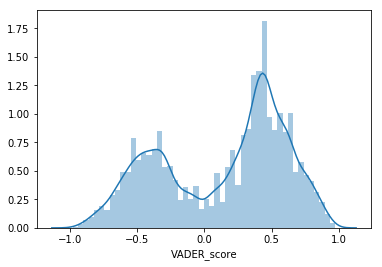

In [64]:
#sns.displot(data = df_vader, x="VADER_score", hue="species", stat="Sentiment", fill=True)
sns.distplot(df_vader_non_zero['VADER_score'])

Mean value: -0.23962540406921534
Std: 0.43320025378065324


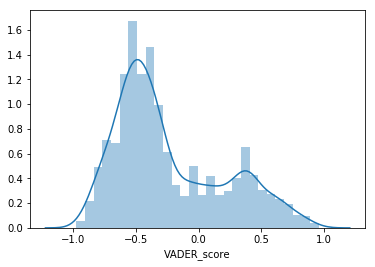

In [65]:
sns.distplot(df_vader_non_zero.loc[df_vader_non_zero['Sentiment'] == 0]['VADER_score'])
print('Mean value:',df_vader_non_zero.loc[df_vader_non_zero['Sentiment'] == 0]['VADER_score'].mean())
print('Std:',df_vader_non_zero.loc[df_vader_non_zero['Sentiment'] == 0]['VADER_score'].std())


In [66]:
df_temp = df_vader_non_zero.loc[df_vader_non_zero['Sentiment'] == 0]
df_temp.loc[df_temp['VADER_score'] > 0.5].sample(5)

,PhraseId,SentenceId,Phrase,Sentiment,clean_review,VADER_score
67637,67638,3435,do n't think most of the people who loved the ...,0,do n t think most of the people who loved the ...,0.5994
91624,91625,4767,"a schmaltzy , by-the-numbers romantic comedy ,...",0,a schmaltzy by the number romantic comedy part...,0.7184
50274,50275,2473,Never having seen the first two films in the s...,0,never having seen the first two film in the se...,0.5927
99726,99727,5232,makes even Jason X ... look positively Shakesp...,0,make even jason x look positively shakesperean...,0.5267
105591,105592,5576,"Coarse , cliched and clunky , this trifling ro...",0,coarse cliched and clunky this trifling romant...,0.9153


Mean value: -0.10923916598528272
Std: 0.43652602277487235


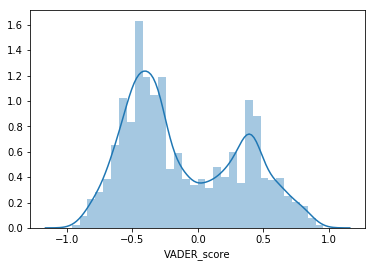

In [67]:
sns.distplot(df_vader_non_zero.loc[df_vader_non_zero['Sentiment'] == 1]['VADER_score'])
print('Mean value:',df_vader_non_zero.loc[df_vader_non_zero['Sentiment'] == 1]['VADER_score'].mean())
print('Std:',df_vader_non_zero.loc[df_vader_non_zero['Sentiment'] == 1]['VADER_score'].std())

Mean value: 0.06945836532507745
Std: 0.43839158549402846


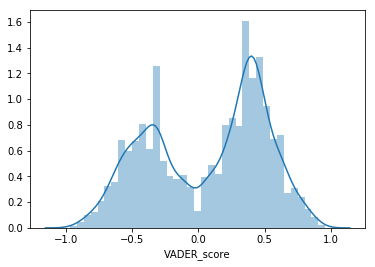

In [68]:
sns.distplot(df_vader_non_zero.loc[df_vader_non_zero['Sentiment'] == 2]['VADER_score'])
print('Mean value:',df_vader_non_zero.loc[df_vader_non_zero['Sentiment'] == 2]['VADER_score'].mean())
print('Std:',df_vader_non_zero.loc[df_vader_non_zero['Sentiment'] == 2]['VADER_score'].std())

Mean value: 0.36805521632114746
Std: 0.3529426414455211


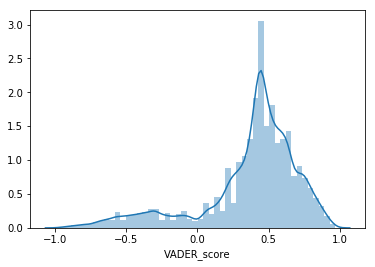

In [69]:
sns.distplot(df_vader_non_zero.loc[df_vader_non_zero['Sentiment'] == 3]['VADER_score'])
print('Mean value:',df_vader_non_zero.loc[df_vader_non_zero['Sentiment'] == 3]['VADER_score'].mean())
print('Std:',df_vader_non_zero.loc[df_vader_non_zero['Sentiment'] == 3]['VADER_score'].std())

Mean value: 0.506208796481403
Std: 0.29923221744090833


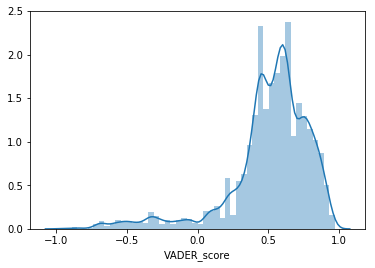

In [70]:
sns.distplot(df_vader_non_zero.loc[df_vader_non_zero['Sentiment'] == 4]['VADER_score'])
print('Mean value:',df_vader_non_zero.loc[df_vader_non_zero['Sentiment'] == 4]['VADER_score'].mean())
print('Std:',df_vader_non_zero.loc[df_vader_non_zero['Sentiment'] == 4]['VADER_score'].std())

### Prediction with logistic regression

In this case we use the logistic regression model to map the vader score to the sentiment score. 

In [91]:
x =df_vader['VADER_score'].values.reshape(-1,1)
y = df_vader['Sentiment'].values.reshape(-1,1)
print(x.shape)
print(y.shape)

(156060, 1)
(156060, 1)


In [124]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
clf.fit(x, y)


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

Lets get the vader score for test data

In [95]:
%%time 


i=0 #counter

compval2 = [ ]  #empty list to hold our computed 'compound' VADER scores


for sentence in df_test['Phrase']:
    if i % 5000 == 0:
        print(i,'samples done')
    k = SentimentIntensityAnalyzer().polarity_scores(sentence)
    compval2.append(k['compound'])   
    i = i+1
    
#converting sentiment values to numpy for easier usage
print('DONE')
compval2 = np.array(compval2)

len(compval2)

0 samples done
5000 samples done
10000 samples done
15000 samples done
20000 samples done
25000 samples done
30000 samples done
35000 samples done
40000 samples done
45000 samples done
50000 samples done
55000 samples done
60000 samples done
65000 samples done
DONE
CPU times: user 13min 52s, sys: 1.36 s, total: 13min 53s
Wall time: 13min 53s


In [97]:
df_test['VADER_score_test'] = compval2


In [125]:
clf_vader_pred = clf.predict(df_test['VADER_score_test'].values.reshape(-1,1))

In [126]:
df_test['VADER_sentiment'] = clf_vader_pred

In [127]:
df_test['VADER_sentiment'].value_counts()

2    49294
3    11308
1     4709
4      532
0      449
Name: VADER_sentiment, dtype: int64

In [128]:
df_test.head()

,PhraseId,SentenceId,Phrase,Sentiment,clean_review,Logistic_Sentiment,lstm_sentiment,VADER_score_test,VADER_sentiment
156060,156061,8545,An intermittently pleasing but mostly routine ...,-999,an intermittently pleasing but mostly routine ...,3,2,0.296,2
156061,156062,8545,An intermittently pleasing but mostly routine ...,-999,an intermittently pleasing but mostly routine ...,3,2,0.296,2
156062,156063,8545,An,-999,an,3,2,0.000,2
156063,156064,8545,intermittently pleasing but mostly routine effort,-999,intermittently pleasing but mostly routine effort,2,2,0.296,2
156064,156065,8545,intermittently pleasing but mostly routine,-999,intermittently pleasing but mostly routine,2,2,0.296,2


In [129]:
df_test.to_csv('sentiment_all_models.csv',index=False)

### Prediction with manual set bins

In [ ]:
%%time 


i=0 #counter

compval2 = [ ]  #empty list to hold our computed 'compound' VADER scores


for sentence in df_test['Phrase']:
    if i % 5000 == 0:
        print(i,'samples done')
    k = SentimentIntensityAnalyzer().polarity_scores(sentence)
    compval2.append(k['compound'])
    
    i = i+1
    
#converting sentiment values to numpy for easier usage
print('DONE')
compval2 = np.array(compval2)

len(compval2)

In [ ]:
df_test['VADER_score'] = compval2


In [ ]:
%time

#Assigning score categories and logic
i = 0

predicted_value = [ ] #empty series to hold our predicted values

while(i<len(df_test)):
    if i % 5000 == 0:
        print(i,'samples done')
    if ((df_test.iloc[i]['VADER_score'] >= 0.4)):
        predicted_value.append(4)
        i = i+1
    elif ((df_test.iloc[i]['VADER_score'] > 0.15) & (df_test.iloc[i]['VADER_score'] < 0.4)):
        predicted_value.append('3')
        i = i+1
    elif ((df_test.iloc[i]['VADER_score'] > -0.075) & (df_test.iloc[i]['VADER_score'] < 0.15)):
        predicted_value.append('2')
        i = i+1
    elif ((df_test.iloc[i]['VADER_score'] > -0.15) & (df_test.iloc[i]['VADER_score'] < -0.075)):
        predicted_value.append('1')
        i = i+1
    elif ((df_test.iloc[i]['VADER_score'] <= -0.15)):
        predicted_value.append('0')
        i = i+1
        

In [ ]:
df_test['VADER_sentiment'] = predicted_value


In [133]:
del df_vader,compval1,compval2,logreg,df_temp,x,y,logreg


NameError: name 'logreg' is not defined

In [132]:
gc.collect()

23173

# CNN 

In [159]:
cnn= Sequential()
cnn.add(Embedding(max_features,100,input_length=max_words))
cnn.add(Conv1D(64,kernel_size=3,padding='same',activation='relu',strides=1))
cnn.add(MaxPooling1D(3))
cnn.add(Conv1D(64,kernel_size=3,padding='same',activation='relu',strides=1))
cnn.add(GlobalMaxPooling1D())
cnn.add(Dense(128,activation='relu'))
cnn.add(Dropout(0.4))
cnn.add(Dense(128))
cnn.add(Dense(5,activation='softmax'))

cnn.summary()
cnn.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 48, 100)           1373200   
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 48, 64)            19264     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 16, 64)            0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 16, 64)            12352     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
__________

In [160]:
%%time
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

num_epochs = 3
batch_size = 128

cnn_history =cnn.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=num_epochs, batch_size=batch_size, verbose=1)

Train on 124848 samples, validate on 31212 samples
Epoch 1/3
124848/124848 [==============================] - 52s 415us/step - loss: 1.0230 - acc: 0.5879 - val_loss: 0.8374 - val_acc: 0.6543
Epoch 2/3
124848/124848 [==============================] - 51s 409us/step - loss: 0.7594 - acc: 0.6875 - val_loss: 0.8050 - val_acc: 0.6695
Epoch 3/3
124848/124848 [==============================] - 52s 415us/step - loss: 0.6538 - acc: 0.7268 - val_loss: 0.8251 - val_acc: 0.6725
CPU times: user 5min 43s, sys: 2min 26s, total: 8min 10s
Wall time: 2min 35s


In [161]:
cnn_pred =cnn.predict_classes(X_test, verbose=1)


66292/66292 [==============================] - 8s 115us/step


In [162]:
df_test['CNN_Sentiment'] = cnn_pred

In [163]:
df_test.to_csv('sentiment_all_models_V2.csv',index=False)

# CNN-LSTM

In [166]:
cnnlstm= Sequential()
cnnlstm.add(Embedding(max_features,100,input_length=max_words))
cnnlstm.add(Conv1D(64,kernel_size=3,padding='same',activation='relu',strides=1))
cnnlstm.add(MaxPooling1D(3))
cnnlstm.add(Conv1D(64,kernel_size=3,padding='same',activation='relu',strides=1))
cnnlstm.add(MaxPooling1D(3))
cnnlstm.add(LSTM(64,dropout=0.4, recurrent_dropout=0.4,return_sequences=False))
cnnlstm.add(Dense(128,activation='relu'))
cnnlstm.add(Dropout(0.4))
cnnlstm.add(Dense(128))
cnnlstm.add(Dense(5,activation='softmax'))

cnnlstm.summary()
cnnlstm.compile(optimizer=Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 48, 100)           1373200   
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 48, 64)            19264     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 16, 64)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 16, 64)            12352     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 5, 64)             0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_22 (Dense)             (None, 128)               8320      
__________

In [167]:
%%time
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

num_epochs = 3
batch_size = 128

cnnlstm_history =cnnlstm.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=num_epochs, batch_size=batch_size, verbose=1)

Train on 124848 samples, validate on 31212 samples
Epoch 1/3
124848/124848 [==============================] - 62s 493us/step - loss: 1.0792 - acc: 0.5670 - val_loss: 0.8948 - val_acc: 0.6383
Epoch 2/3
124848/124848 [==============================] - 59s 475us/step - loss: 0.8188 - acc: 0.6679 - val_loss: 0.8124 - val_acc: 0.6650
Epoch 3/3
124848/124848 [==============================] - 59s 476us/step - loss: 0.7195 - acc: 0.7014 - val_loss: 0.8119 - val_acc: 0.6589
CPU times: user 6min 41s, sys: 2min 44s, total: 9min 26s
Wall time: 3min 2s


In [168]:
cnnlstm_pred = cnnlstm.predict_classes(X_test, verbose=1)


66292/66292 [==============================] - 11s 171us/step


In [169]:
df_test['CNN-LSTM_Sentiment'] = cnnlstm_pred

In [170]:
df_test.to_csv('sentiment_all_models_V3.csv',index=False)